In [185]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [186]:
!cd gdrive; cd "My Drive"; cd ml/siamese_network; ls

face_data


In [0]:
from keras.preprocessing.image import ImageDataGenerator
import os


In [0]:
data_path = "gdrive/My Drive/ml/siamese_network/face_data"

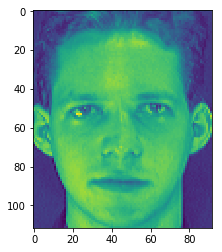

In [189]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

img=mpimg.imread(data_path + "/s1/1.pgm")
plt.imshow(img)

In [190]:
print(img.shape)
input_shape = (112, 92, 1)

(112, 92)


In [0]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle


In [0]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def siamese(input_shape):

    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    convnet = Sequential()
    convnet.add(Conv2D(32,(3,3),padding='valid',activation='relu',input_shape=input_shape))
    convnet.add(Conv2D(64,(3,3),padding='valid',activation='relu',input_shape=input_shape))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(.25))
    
    convnet.add(Flatten())
    convnet.add(Dense(516,activation="sigmoid"))

    #call the convnet Sequential model on each of the input tensors so params will be shared
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)
    #layer to merge two encoded inputs with the l1 distance between them
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    #call this layer on list of two input tensors.
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net


In [193]:
from tensorflow.python.client import device_lib
import tensorflow as tf

siamese_net = siamese(input_shape)

with tf.device('/gpu:0'):
  siamese_net.compile(loss="binary_crossentropy",optimizer=Adam(0.00006),metrics=['accuracy'])

siamese_net.count_params()

78484873

In [194]:
for layer in siamese_net.layers:
    print(layer.output_shape)

(None, 112, 92, 1)
(None, 112, 92, 1)
(None, 516)
(None, 516)
(None, 1)


In [195]:
siamese_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 516)          78484356    input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 516)          0           sequential_4[1][0]               
          

In [196]:
import random

a = (os.listdir(data_path))
a = a[0:a.index('README')] + a[a.index('README')+1:]
c = len(a)
x1 = []
x2 = []
y = []
cnt = 0
for i in tqdm(range(0,c)):
  for j in range(i,c):
    c0 = os.listdir(data_path + "/" + a[i])
    c1 = os.listdir(data_path + "/" + a[j])
    match = False
    for first in c0:
      for second in c1:
        cnt+= 1
print(cnt)

100%|██████████| 40/40 [00:00<00:00, 52.95it/s]

82000


In [197]:
cnt

82000

In [198]:
a = (os.listdir(data_path))
a = a[0:a.index('README')] + a[a.index('README')+1:]
len(a)

40

In [0]:
files = []
x1 = []
x2 = []
a = (os.listdir(data_path))
a = a[0:a.index('README')] + a[a.index('README')+1:]
c = len(a)
y = []
batch = 0
for i in range(0,c):
  for j in range(i,c):
    c0 = os.listdir(data_path + "/" + a[i])
    c1 = os.listdir(data_path + "/" + a[j])
    match = 0
    for first in c0:
      for second in c1:
        if(i==j):
          match = 1
        path1 = data_path + "/" + a[i] + "/" + first
        path2 = data_path + "/" + a[j] + "/" + second
        files.append((path1+"$"+path2))
        y.append(match)

In [200]:
idx =2131
files[idx], y[idx]

('gdrive/My Drive/ml/siamese_network/face_data/s3/9.pgm$gdrive/My Drive/ml/siamese_network/face_data/s24/8.pgm',
 0)

In [0]:
def image_generator(files,batch_size = 1):

    while True:
          # Select files (paths/indices) for the batch
          batch_paths = np.random.choice(a = files, size = batch_size)
  
          input1 = []
          input2 = []
          y = []
      
          for i in batch_paths:
            img1_path, img2_path=i.split("$")
            img1 = (mpimg.imread(img1_path)).reshape(112,92,1)
            img2 = (mpimg.imread(img2_path)).reshape(112,92,1)
            input1.append(img1/255)
            input2.append(img2/255)
              
            y_ = 0
            img1_path = img1_path[45:]
            index1 = img1_path.find('/')
            class1 = img1_path[:index1]
            img2_path = img2_path[45:]
            index2 = img2_path.find('/')
            class2 = img1_path[:index2]
            if(class2 == class1):
              y_ = 1
            y.append(y_)
            
          #(2, 1, 112, 92, 1)
          batch_x = np.asarray([input1, input2])
          batch_y = np.array(y)
          #print(batch_x.shape)
        
          yield  ([np.array(input1),np.array(input2)], batch_y)

In [18]:
import math
batch_size = 64
steps = 82000/batch_size
hist = siamese_net.fit_generator(image_generator(files),steps_per_epoch=82000/64,epochs=20, verbose=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1282/1281 [==============================] - 190s 149ms/step - loss: 0.5545 - acc: 0.7371
Epoch 2/5
1282/1281 [==============================] - 98s 76ms/step - loss: 0.3282 - acc: 0.8908
Epoch 3/5
1282/1281 [==============================] - 98s 76ms/step - loss: 0.1471 - acc: 0.9704
Epoch 4/5
1282/1281 [==============================] - 98s 76ms/step - loss: 0.0814 - acc: 0.9867
Epoch 5/5
1282/1281 [==============================] - 98s 76ms/step - loss: 0.0402 - acc: 0.9977


In [0]:
model_json = siamese_net.to_json()
with open("siamese_net.json", "w") as json_file : 
    json_file.write(model_json)


siamese_net.save_weights("siamese_net_w.h5")
print("Saved model to disk")

Saved model to disk


In [30]:
img1=mpimg.imread(data_path + "/s1/1.pgm").reshape(1,112,92,1)
img2=mpimg.imread(data_path + "/s1/5.pgm").reshape(1,112,92,1)
siamese_net.predict([img1,img2])

array([[0.9604287]], dtype=float32)

MNIST

In [0]:
from keras.datasets import mnist

(X_train, Y_train),(X_validation, Y_validation) = mnist.load_data()

In [155]:
X = np.concatenate((X_train, X_validation))
Y = np.concatenate((Y_train, Y_validation))
print(X.shape, Y.shape)

(70000, 28, 28) (70000,)


In [156]:
X_train = []
Y_train = []
X_validation = []
Y_validation = []
validation_class = [8,9]
for i in tqdm(range(X.shape[0])):
  if(Y[i] in validation_class):
    X_validation.append(X[i])
    Y_validation.append(Y[i])
  else:
    X_train.append(X[i])
    Y_train.append(Y[i])

100%|██████████| 70000/70000 [00:00<00:00, 250941.69it/s]


In [157]:
len(X_train), len(Y_train)

(56217, 56217)

In [0]:
del X
del Y

In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [0]:
num_classes = 10
epochs = 20

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)


In [161]:
from keras.optimizers import RMSprop

rms = RMSprop()
with tf.device('/gpu:0'):
  model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 5s 46us/step - loss: 0.0986 - accuracy: 0.8817 - val_loss: 0.0452 - val_accuracy: 0.9511
Epoch 2/20
108400/108400 [==============================] - 4s 35us/step - loss: 0.0426 - accuracy: 0.9579 - val_loss: 0.0317 - val_accuracy: 0.9675
Epoch 3/20
108400/108400 [==============================] - 4s 36us/step - loss: 0.0298 - accuracy: 0.9715 - val_loss: 0.0280 - val_accuracy: 0.9694
Epoch 4/20
108400/108400 [==============================] - 4s 35us/step - loss: 0.0241 - accuracy: 0.9768 - val_loss: 0.0252 - val_accuracy: 0.9728
Epoch 5/20
108400/108400 [==============================] - 4s 35us/step - loss: 0.0205 - accuracy: 0.9799 - val_loss: 0.0248 - val_accuracy: 0.9728
Epoch 6/20
108400/108400 [==============================] - 4s 37us/step - loss: 0.0183 - accuracy: 0.9821 - val_loss: 0.0240 - val_accuracy: 0.9726
Epoch 7/20
108400/108400 [=============================

In [162]:
a = 10
b = 25
model.predict([tr_pairs[:,0][a:a+1],tr_pairs[:,1][b:b+1]])

array([[1.4079069]], dtype=float32)

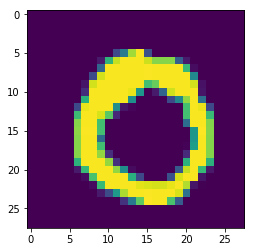

In [163]:
plt.imshow(tr_pairs[:,0][a:a+1].reshape(28,28))

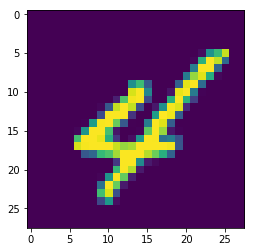

In [164]:
plt.imshow(tr_pairs[:,1][b])

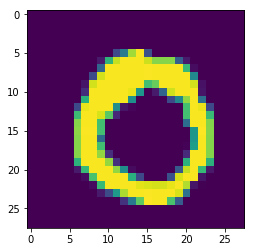

In [165]:
plt.imshow(tr_pairs[:,0][10])

In [0]:
preds = []
for i in tr_pairs[:,1]:
  i = i.reshape(1,28,28)
  preds.append(model.predict([tr_pairs[:,0][10:10+1],i]))

In [183]:
idx_ = 918
preds[idx_]

array([[0.00650157]], dtype=float32)

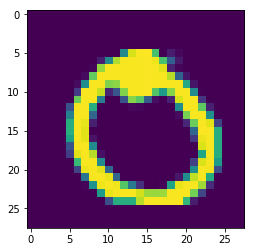

In [184]:
plt.imshow(tr_pairs[:,1][idx_])

VGG baseline -> 

In [0]:
from keras import applications
from keras import regularizers

def siamese_vgg(input_shape):

    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    vgg_base = Sequential()
    vgg_base.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    vgg_base.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    vgg_base.add(MaxPooling2D((2,2)))
 
    vgg_base.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    vgg_base.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    vgg_base.add(MaxPooling2D((2,2)))
 
    vgg_base.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    vgg_base.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    vgg_base.add(MaxPooling2D((2,2)))
 
    vgg_base.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    vgg_base.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    vgg_base.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    vgg_base.add(MaxPooling2D((2,2)))
 
    vgg_base.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    vgg_base.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    vgg_base.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)))
    vgg_base.add(MaxPooling2D((2,2)))

    vgg_base.add(Flatten())
    vgg_base.add(Dense(2048,activation="sigmoid"))

    #call the convnet Sequential model on each of the input tensors so params will be shared
    encoded_l = vgg_base(left_input)
    encoded_r = vgg_base(right_input)
    #layer to merge two encoded inputs with the l1 distance between them
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    #call this layer on list of two input tensors.
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net


In [205]:
from tensorflow.python.client import device_lib
import tensorflow as tf

siamese_vgg_net = siamese_vgg(input_shape)

with tf.device('/gpu:0'):
  siamese_vgg_net.compile(loss="binary_crossentropy",optimizer=Adam(0.00006),metrics=['accuracy'])

siamese_vgg_net.count_params()

20419009

In [206]:
siamese_vgg_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 2048)         20416960    input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 2048)         0           sequential_6[1][0]               
          

In [207]:
import math
batch_size = 64
steps = 82000/batch_size
hist = siamese_vgg_net.fit_generator(image_generator(files),steps_per_epoch=82000/64,epochs=20, verbose=1)


Epoch 1/20
1282/1281 [==============================] - 72s 56ms/step - loss: 24.9724 - acc: 0.6240
Epoch 2/20
1282/1281 [==============================] - 67s 52ms/step - loss: 2.7320 - acc: 0.6490
Epoch 3/20
1282/1281 [==============================] - 67s 52ms/step - loss: 1.4781 - acc: 0.6763
Epoch 4/20
1282/1281 [==============================] - 67s 52ms/step - loss: 1.2175 - acc: 0.6576
Epoch 5/20
1282/1281 [==============================] - 67s 52ms/step - loss: 1.0533 - acc: 0.6404
Epoch 6/20
1282/1281 [==============================] - 67s 52ms/step - loss: 0.9443 - acc: 0.6498
Epoch 7/20
1282/1281 [==============================] - 66s 52ms/step - loss: 0.8625 - acc: 0.6638
Epoch 8/20
1282/1281 [==============================] - 67s 52ms/step - loss: 0.8000 - acc: 0.6693
Epoch 9/20
1282/1281 [==============================] - 67s 52ms/step - loss: 0.7668 - acc: 0.6568
Epoch 10/20
1282/1281 [==============================] - 67s 52ms/step - loss: 0.7397 - acc: 0.6404
Epoch 11

In [222]:
img1=mpimg.imread(data_path + "/s1/10.pgm").reshape(1,112,92,1)
img2=mpimg.imread(data_path + "/s1/9.pgm").reshape(1,112,92,1)
siamese_vgg_net.predict([img1,img2])

array([[0.9450252]], dtype=float32)

In [223]:
model_json = siamese_vgg_net.to_json()
with open("siamese_net_vgg.json", "w") as json_file : 
    json_file.write(model_json)

siamese_vgg_net.save_weights("siamese_net__vgg__w.h5")
print("Saved model to disk")

Saved model to disk
